In [0]:
# Load all the required libraries
import numpy as np
import pandas as pd
import re,string
from sklearn import preprocessing
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Upload the csv file containing target tweets
from google.colab import files
uploaded = files.upload()

Saving trgtw2.csv to trgtw2.csv


In [174]:
# Load the target tweets of scholars (each at a time)
tar = pd.read_csv('trgtw2.csv')
test = tar['Target tweets']
test.head()

0    When happy smoke weed when sad smoke weed all ...
1    you dont like weed all you have not smoke and ...
2    You ever be high you have change you breathe f...
3                                    Gunna Lil Baby \n
4                  NowPlaying Wiz khalifa Lil Skies \n
Name: Target tweets, dtype: object

In [3]:
# Upload the "text_emotion.csv" dataset which we will use to train the classification model (i.e., text-emotion detection model)
from google.colab import files
uploaded = files.upload()

Saving text_emotion.csv to text_emotion.csv


In [175]:
# Load the dataset to train the model
df = pd.read_csv('text_emotion.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [176]:
# Number of tweets showing a particular sentiment
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [0]:
# Removing those sentiments which are making the dataset imbalanced
df = df.drop(df[df.sentiment == 'anger'].index)
df = df.drop(df[df.sentiment == 'empty'].index)
df = df.drop(df[df.sentiment == 'surprise'].index)
df = df.drop(df[df.sentiment == 'boredom'].index)
df = df.drop(df[df.sentiment == 'enthusiasm'].index)
df = df.drop(df[df.sentiment == 'hate'].index)
df = df.drop(df[df.sentiment == 'love'].index)

In [178]:
# Number of tweets belonging to a particular sentiment after removing rows belonging to above 7 sentiments
df['sentiment'].value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
fun          1776
relief       1526
Name: sentiment, dtype: int64

Since even after removing rows belonging to the sentiments having less number of tweets, the dataset is not so much balanced. That's why we are performing random oversampling in order to make it balanced.

In [0]:
c1 = df['sentiment'] == 'happiness'
df_rep = df[c1]
df= df.append([df_rep]*2,ignore_index=True)

In [0]:
c2 = df['sentiment'] == 'sadness'
df_rep = df[c2]
df= df.append([df_rep]*2,ignore_index=True)

In [0]:
c3 = df['sentiment'] == 'worry'
df_rep = df[c3]
df= df.append([df_rep]*1,ignore_index=True)

In [0]:
c3 = df['sentiment'] == 'neutral'
df_rep = df[c3]
df= df.append([df_rep]*1,ignore_index=True)

In [0]:
# Run 3rd line first keeping the 4th line as comment, then run the 4th line keeping the 3rd line commented
c3 = df['sentiment'] == 'relief'
df_rep = df[c3]
#df= df.append([df_rep]*3,ignore_index=True)
df= df.append([df_rep]*1,ignore_index=True)

In [0]:
# Run 3rd line first keeping the 4th line as comment, then run the 4th line keeping the 3rd line commented
c4 = df['sentiment'] == 'fun'
df_rep = df[c4]
#df= df.append([df_rep]*3,ignore_index=True)
df= df.append([df_rep]*1,ignore_index=True)

Now dataset is quite balanced so we can proceed further

In [189]:
df['sentiment'].value_counts()

neutral      17276
worry        16918
happiness    15627
sadness      15495
fun          14208
relief       12208
Name: sentiment, dtype: int64

In [190]:
# For training purpose we are considering along labeled data (i.e., tweet text along with their corresponding sentiments)
data = df[['sentiment','content']]
data.head()

,sentiment,content
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,neutral,@dannycastillo We want to trade with someone w...
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sadness,"I should be sleep, but im not! thinking about ..."


Data Preprocessing and Cleaning

In [191]:
# Function to clean the 'text_emotion.csv' data
def clean(txt):
    txt = re.sub(r'@[A-Za-z0-9]+','', txt) # Removed mentions
    txt = re.sub(r'#','', txt) # Removed '#' symbol
    txt = re.sub(r'\n','', txt)
    txt = re.sub(r'RT[\s]+','', txt) # Remove RT
    txt = re.sub(r'https?:\/\/\S+','', txt) # Hyperlinks
    
    return txt
# Cleaning the tweets
data['content'] = data['content'].apply(clean)
# Show clean text
data['content'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0    Layin n bed with a headache  ughhhh...waitin o...
1                  Funeral ceremony...gloomy friday...
2     We want to trade with someone who has Houston...
3    Re-pinging : why didn't you go to prom? BC my ...
4    I should be sleep, but im not! thinking about ...
Name: content, dtype: object

In [192]:
# Clean the target tweets, if it contain unwanted words
test = test.apply(clean)
test.head()

0    When happy smoke weed when sad smoke weed all ...
1    you dont like weed all you have not smoke and ...
2    You ever be high you have change you breathe f...
3                                      Gunna Lil Baby 
4                    NowPlaying Wiz khalifa Lil Skies 
Name: Target tweets, dtype: object

In [0]:
# data.content.values

In [0]:
# Function to remove punctuations
data = data.dropna()
def r_punc(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc

In [0]:
# Remove the punctuation if target tweets contain any punctutation
#test = test.apply(lambda x : r_punc(x))

In [196]:
data['content'] = data['content'].apply(lambda x : r_punc(x))
data['content'].head()

0    Layin n bed with a headache  ughhhhwaitin on y...
1                        Funeral ceremonygloomy friday
2     We want to trade with someone who has Houston...
3    Repinging  why didnt you go to prom BC my bf d...
4    I should be sleep but im not thinking about an...
Name: content, dtype: object

In [0]:
# Tokenization
tokenizer = RegexpTokenizer(r'\w+')

In [198]:
data['content'] = data['content'].apply(lambda x : tokenizer.tokenize(x.lower()))
data['content'].head()

0    [layin, n, bed, with, a, headache, ughhhhwaiti...
1                    [funeral, ceremonygloomy, friday]
2    [we, want, to, trade, with, someone, who, has,...
3    [repinging, why, didnt, you, go, to, prom, bc,...
4    [i, should, be, sleep, but, im, not, thinking,...
Name: content, dtype: object

In [199]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Function to remove english stopwords 
def st_words(text):
    en_stops = set(stopwords.words('english'))
    words = [w for w in text if w not in en_stops]
    return words

In [201]:
# Remove stopwords from the tweet texts
data['content'] = data['content'].apply(lambda x : st_words(x))
data['content'].head()

0        [layin, n, bed, headache, ughhhhwaitin, call]
1                    [funeral, ceremonygloomy, friday]
2        [want, trade, someone, houston, tickets, one]
3    [repinging, didnt, go, prom, bc, bf, didnt, li...
4    [sleep, im, thinking, old, friend, want, hes, ...
Name: content, dtype: object

In [202]:
# Natural language toolkit
# Download 'wordnet' 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# Function to lemmatize the tweet texts
lemmatizer = WordNetLemmatizer()
def word_lem(text):
    l_txt = [lemmatizer.lemmatize(i) for i in text]
    return l_txt

In [204]:
# Lemmatize the tweet texts
data['content'] = data['content'].apply(lambda x : word_lem(x))
data['content'].head()

0        [layin, n, bed, headache, ughhhhwaitin, call]
1                    [funeral, ceremonygloomy, friday]
2         [want, trade, someone, houston, ticket, one]
3    [repinging, didnt, go, prom, bc, bf, didnt, li...
4    [sleep, im, thinking, old, friend, want, he, m...
Name: content, dtype: object

In [0]:
# Function for stemming
stemmer = PorterStemmer()
def word_stem(text):
    stm_txt = " ".join([stemmer.stem(i) for i in text])
    return stm_txt

In [206]:
# Perform stemming on tweet texts
data['content'] = data['content'].apply(lambda x : word_stem(x))
data['content'].head()

0                layin n bed headach ughhhhwaitin call
1                          funer ceremonygloomi friday
2                 want trade someon houston ticket one
3         reping didnt go prom bc bf didnt like friend
4    sleep im think old friend want he marri damn a...
Name: content, dtype: object

Once the tweet texts are cleaned add another column to dataframe 'data' which represents each emotion by some number

In [0]:
le = preprocessing.LabelEncoder()

In [209]:
sent = data['sentiment']
label = le.fit_transform(sent)
label

array([4, 4, 2, ..., 3, 3, 3])

In [210]:
# Assigning labels to each emotion
data["label"] = label
data.head()

,sentiment,content,label
0,sadness,layin n bed headach ughhhhwaitin call,4
1,sadness,funer ceremonygloomi friday,4
2,neutral,want trade someon houston ticket one,2
3,worry,reping didnt go prom bc bf didnt like friend,5
4,sadness,sleep im think old friend want he marri damn a...,4


In [211]:
le.classes_

array(['fun', 'happiness', 'neutral', 'relief', 'sadness', 'worry'],
      dtype=object)

In [0]:
# Just to check whether it is working or not
# list(le.inverse_transform([1,4,3]))

In [0]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)

In [214]:
y

array([4, 4, 2, ..., 3, 3, 3])

In [215]:
X1 = data['content'].values
y1 = y
print(X1.shape)
print(y1.shape)

(91732,)
(91732,)


In [216]:
# Dividing whole dataset into training dataset(75% of total) and testing dataset(25% of total)
X_train, X_test, y_train, y_test = train_test_split(X1,y1,test_size=0.10, random_state = 2000, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82558,)
(9174,)
(82558,)
(9174,)


In [0]:
# Feauturization using CountVectorizer()
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)

In [218]:
X_train_counts

<82558x25008 sparse matrix of type '<class 'numpy.int64'>'
	with 590789 stored elements in Compressed Sparse Row format>

In [219]:
X_train_counts.shape

(82558, 25008)

In [220]:
# Featurization using TfidfTransformer()
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(82558, 25008)

Model 1 : Multinomial Naive Bayes model using Tfidf outcomes

In [221]:
# Model 1 : Training Multinomial Naive Bayes model using Tfidf vectorization
model1 = MultinomialNB().fit(X_train_tfidf,y_train)
text_model1 = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()), ('model1', MultinomialNB()),])
%time text_model1 = text_model1.fit(X_train, y_train)

CPU times: user 825 ms, sys: 10 ms, total: 835 ms
Wall time: 835 ms


In [222]:
# Predicting emotions for the testing data of "data"
y_pred1 = text_model1.predict(X_test)
y_pred1

array([3, 1, 1, ..., 5, 5, 5])

In [223]:
le.inverse_transform(y_pred1)

array(['relief', 'happiness', 'happiness', ..., 'worry', 'worry', 'worry'],
      dtype=object)

In [224]:
print("Accuracy of MultinomialNB Model 1 is : ",(text_model1.score(X_test,y_test))*100)

Accuracy of MultinomialNB Model 1 is :  63.83257030739045


In [225]:
# Applying the model to get emotions for each target tweet
y_pr = text_model1.predict(test)
le.inverse_transform(y_pr)

array(['worry', 'worry', 'worry', 'relief', 'fun', 'sadness', 'happiness',
       'worry', 'worry', 'neutral', 'worry', 'neutral', 'sadness',
       'neutral', 'fun', 'worry', 'happiness', 'worry', 'happiness',
       'happiness', 'happiness', 'neutral', 'happiness', 'worry', 'worry',
       'happiness', 'sadness', 'happiness', 'happiness', 'worry',
       'happiness', 'neutral', 'happiness', 'happiness', 'neutral', 'fun',
       'sadness', 'sadness', 'worry', 'sadness', 'happiness', 'relief',
       'happiness', 'happiness', 'fun', 'relief', 'relief', 'sadness',
       'worry', 'worry', 'worry', 'sadness', 'fun', 'fun', 'worry',
       'happiness', 'worry', 'worry', 'fun', 'happiness', 'happiness',
       'relief', 'happiness', 'relief', 'relief', 'happiness', 'worry',
       'neutral', 'sadness', 'fun', 'relief', 'fun', 'happiness',
       'happiness', 'happiness', 'sadness', 'worry', 'worry', 'worry',
       'fun', 'worry', 'worry', 'worry', 'neutral', 'happiness'],
      dtype=obje

Model 2 : Multinomial Naive Bayes model using CountVectorizer outcomes

In [226]:
# Model2 : Training Multinomial Naive Bayes model using CountVectorizer outcomes
model2 = MultinomialNB()
%time model2.fit( X_train_counts, y_train)

CPU times: user 35.6 ms, sys: 1.99 ms, total: 37.6 ms
Wall time: 44.1 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [227]:
# Predicting emotions for testing data of "data"
X_test_counts = count_vec.transform(X_test)
X_test_counts

<9174x25008 sparse matrix of type '<class 'numpy.int64'>'
	with 65190 stored elements in Compressed Sparse Row format>

In [228]:
y_pred2 = model2.predict(X_test_counts)
y_pred2

array([3, 1, 1, ..., 1, 5, 5])

In [229]:
from sklearn import metrics
print("Accuracy of MultinomialNB Model 2 is : ",(metrics.accuracy_score(y_test,y_pred2))*100)

Accuracy of MultinomialNB Model 2 is :  62.40462175713974


Testing target tweets

In [230]:
test.head()

0    When happy smoke weed when sad smoke weed all ...
1    you dont like weed all you have not smoke and ...
2    You ever be high you have change you breathe f...
3                                      Gunna Lil Baby 
4                    NowPlaying Wiz khalifa Lil Skies 
Name: Target tweets, dtype: object

In [231]:
X_test_counts1 = count_vec.transform(test)
X_test_counts1

<85x25008 sparse matrix of type '<class 'numpy.int64'>'
	with 469 stored elements in Compressed Sparse Row format>

Model 3 : Linear support vector machine using CountVectorizer outcomes

In [232]:
lsvm = SGDClassifier(alpha=0.0001, random_state=5, max_iter=10, tol=None)
lsvm.fit(X_train_counts, y_train)
# Predicting emotions for testing data of "data"
y_pred = lsvm.predict(X_test_counts)
print('lsvm using count vectors accuracy %s' % round(metrics.accuracy_score(y_pred, y_test)*100))

lsvm using count vectors accuracy 65.0


In [0]:
# Predicting emotions of each target tweet
y_pred11 = lsvm.predict(X_test_counts1)
tar11 = le.inverse_transform(y_pred11)

In [234]:
# Create a dataframe to store output of target tweets using lsvm model
tar21 = pd.DataFrame(tar11)
tar21[0].value_counts()

worry        23
neutral      19
happiness    15
sadness      12
fun          10
relief        6
Name: 0, dtype: int64

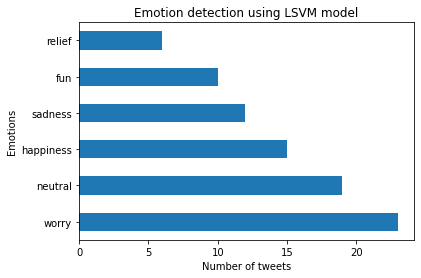

In [246]:
tar21[0].value_counts().plot(kind = 'barh')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')
plt.title('Emotion detection using LSVM model')
plt.savefig("tar2_ls.jpg", dpi = 200, bbox_inches = 'tight')

Model 4 : Random forest classifier model using CountVectorizer outcomes

In [0]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train_counts, y_train)
y_pred3 = rf.predict(X_test_counts)

In [241]:
print('random forest with count vectors accuracy %s' % (metrics.accuracy_score(y_pred3, y_test)*100))

random forest with count vectors accuracy 95.9886636145629


In [0]:
# Predicting emotions of each target tweet
y_pred31 = rf.predict(X_test_counts1)
tar1 = le.inverse_transform(y_pred31)

In [243]:
# Create a dataframe to store output of target tweets using rf model
tar2 = pd.DataFrame(data = tar1)
tar2[0].value_counts()

neutral      41
worry        21
sadness      11
happiness    10
relief        1
fun           1
Name: 0, dtype: int64

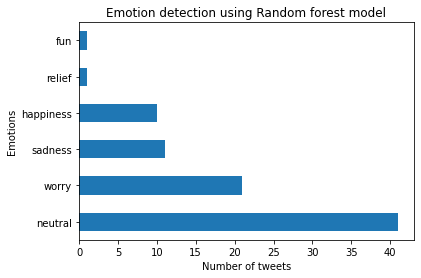

In [245]:
tar2[0].value_counts().plot(kind = 'barh')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')
plt.title('Emotion detection using Random forest model')
#plt.show()
plt.savefig("tar2_rf.jpg", dpi = 200, bbox_inches = 'tight')

Download the bar graph

In [0]:
files.download('tar2_ls.jpg')

In [0]:
files.download('tar2_rf.jpg')

Performance of classification model using classification_report()

In [0]:
['neutral', 'worry', 'happiness', 'sadness', 'relief', 'fun']

In [0]:
from sklearn.metrics import classification_report

In [248]:
target_names = ['fun', 'happiness', 'neutral', 'relief', 'sadness', 'worry']
target_names

['fun', 'happiness', 'neutral', 'relief', 'sadness', 'worry']

In [249]:
r1 = classification_report(y_test,y_pred, target_names = target_names,output_dict = True)
pd.DataFrame(r1)

,fun,happiness,neutral,relief,sadness,worry,accuracy,macro avg,weighted avg
precision,0.720223,0.639222,0.612748,0.722814,0.604330,0.581776,0.6477,0.646852,0.641526
recall,0.845594,0.712102,0.533731,0.793911,0.641762,0.437098,0.6477,0.660700,0.647700
f1-score,0.777889,0.673697,0.570517,0.756696,0.622484,0.499165,0.6477,0.650075,0.640786
support,1373.000000,1570.000000,1675.000000,1281.000000,1566.000000,1709.000000,0.6477,9174.000000,9174.000000


In [250]:
r2 = classification_report(y_test,y_pred3, target_names = target_names, output_dict = True)
pd.DataFrame(r2)

,fun,happiness,neutral,relief,sadness,worry,accuracy,macro avg,weighted avg
precision,0.988406,0.966667,0.927588,0.961509,0.960149,0.960674,0.959887,0.960832,0.959836
recall,0.993445,0.978981,0.925373,0.994536,0.984674,0.900527,0.959887,0.962923,0.959887
f1-score,0.990919,0.972785,0.926479,0.977744,0.972257,0.929629,0.959887,0.961635,0.959607
support,1373.000000,1570.000000,1675.000000,1281.000000,1566.000000,1709.000000,0.959887,9174.000000,9174.000000


Performance of Classification models using confusion matrix



In [0]:
# To check performance of Classification
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test,y_pred1) #MultinomialNB
cm2 = confusion_matrix(y_test,y_pred) #lsvm
cm3 = confusion_matrix(y_test,y_pred3) #rf

In [264]:
# Confusion matrix for lsvm model
cm2

array([[1161,  102,   39,   25,   13,   33],
       [ 111, 1118,  110,   80,   69,   82],
       [ 124,  206,  894,  122,  162,  167],
       [  33,   91,   57, 1017,   36,   47],
       [  71,   94,  125,   63, 1005,  208],
       [ 112,  138,  234,  100,  378,  747]])

In [265]:
# Confusion matrix for rf model
cm3

array([[1364,    3,    0,    6,    0,    0],
       [   5, 1537,   16,    8,    3,    1],
       [   3,   27, 1550,   23,   17,   55],
       [   3,    1,    3, 1274,    0,    0],
       [   2,    1,   13,    1, 1542,    7],
       [   3,   21,   89,   13,   44, 1539]])

In [0]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def overall_precision(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def Accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [0]:
# Performance of Model 3 (RF model)
l1=[]
p1=[]
r1=[]
for label in range(6):
    l1.append(f"{label:5d}")
    p1.append(f"{precision(label, cm3):9.3f}")
    r1.append(f"{recall(label, cm3):6.3f}")

In [0]:
emo = ['fun', 'happiness', 'neutral', 'relief', 'sadness', 'worry']

In [263]:
emo

['fun', 'happiness', 'neutral', 'relief', 'sadness', 'worry']

In [266]:
# dictionary of lists
dict = {"Emotion":emo,"Label":l1,"Precision":p1,"Recall":r1}
rdf1 = pd.DataFrame(dict)
rdf1

,Emotion,Label,Precision,Recall
0,fun,0,0.988,0.993
1,happiness,1,0.967,0.979
2,neutral,2,0.928,0.925
3,relief,3,0.962,0.995
4,sadness,4,0.960,0.985
5,worry,5,0.961,0.901


In [275]:
print("Model 4 : Overall Precision (in %age) is", (overall_precision(cm3))*100)

Model 4 : Overall Precision (in %age) is 96.08322941886591


In [277]:
print("Model 4 : Calculated Overall Accuracy (in %age) is", (Accuracy(cm3))*100)

Model 4 : Calculated Overall Accuracy (in %age) is 95.9886636145629


In [0]:
# Performance of Model 3
l2=[]
p2=[]
r2=[]
for label in range(6):
    l2.append(f"{label:5d}")
    p2.append(f"{precision(label, cm2):9.3f}")
    r2.append(f"{recall(label, cm2):6.3f}")

In [272]:
# dictionary of lists
dict = {"Emotion":emo,"Label":l2,"Precision":p2,"Recall":r2}
rdf2 = pd.DataFrame(dict)
rdf2

,Emotion,Label,Precision,Recall
0,fun,0,0.720,0.846
1,happiness,1,0.639,0.712
2,neutral,2,0.613,0.534
3,relief,3,0.723,0.794
4,sadness,4,0.604,0.642
5,worry,5,0.582,0.437


In [280]:
print("Model 3 : Overall Precision (in %age) is", (overall_precision(cm2))*100)

Model 3 : Overall Precision (in %age) is 64.68523200900961


In [281]:
print("Model 3 : Calculated Overall Accuracy (in %age) is", (Accuracy(cm2))*100)

Model 3 : Calculated Overall Accuracy (in %age) is 64.77000218007413


In [0]:
# Note : Accuracy calculated using confusion matrix and accuracy given by accuracy() function (of metric library) is same.